In [ ]:
# %load_ext autoreload
# %autoreload 2

# Set Trial Name

In [2]:
TRIAL_NAME = "32_fix_maker_date_and_place_and_production_place"

import datetime
import pytz
NOW = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')

# Load yaml

In [3]:
import yaml
CONFIG_DIR = '../config'
with open(f'{CONFIG_DIR}/run000.yml') as file:
    cfg = yaml.safe_load(file)

import sys
sys.path.append(cfg['SRC_DIR'])
cfg['run_name'] = TRIAL_NAME

# fix seed

In [4]:
from util import seed_everything
seed_everything(seed=33, use_torch=False)

# Make Output Folder

In [5]:
import os
OUTPUT_DIR = f'../../output/{NOW}_{TRIAL_NAME}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Model

In [6]:
import pandas as pd
import numpy as np

sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')
color = pd.read_csv('../../data/color.csv')
historical_person = pd.read_csv('../../data/historical_person.csv')

# maker = pd.read_csv('../../data/maker.csv')
maker = pd.read_csv('../../extract_data/maker_rename.csv')

material = pd.read_csv('../../data/material.csv')
object_collection = pd.read_csv('../../data/object_collection.csv')
palette = pd.read_csv('../../data/palette.csv')
principal_maker_occupation = pd.read_csv('../../data/principal_maker_occupation.csv')
principal_maker = pd.read_csv('../../data/principal_maker.csv')

#production_place = pd.read_csv('../../data/production_place.csv')
production_place = pd.read_csv('../../extract_data/production_place_rename.csv')

technique = pd.read_csv('../../data/technique.csv')
test = pd.read_csv('../../data/test.csv')
test[cfg['target']] = np.nan
train = pd.read_csv('../../data/train.csv')

# del_non_overlapping_list

In [7]:
del_non_overlapping_list = [
    # 'object_id',
    'art_series_id',
    'title',
    #'description',
    #'long_title',
    'principal_maker',
    'principal_or_first_maker',
    #'sub_title',
    'copyright_holder',
    #'more_title',
    'acquisition_method',
    # 'acquisition_date',
    # 'acquisition_credit_line',
    # 'dating_presenting_date',
    # 'dating_sorting_date',
    'dating_period',
    # 'dating_year_early',
    # 'dating_year_late'
]

from util import replace_non_overlap_val_to_missing
train, test = replace_non_overlap_val_to_missing(train,test,columns=del_non_overlapping_list)

In [8]:
def del_non_overlapping(input_df: pd.DataFrame()):
    # for material
    train_oblect_id = train['object_id'].unique().tolist()
    test_oblect_id = test['object_id'].unique().tolist()

    train_value = set(input_df[input_df['object_id'].isin(train_oblect_id)]['name'].unique().tolist())
    test_value = set(input_df[input_df['object_id'].isin(test_oblect_id)]['name'].unique().tolist())

    common_value_list = list(train_value & test_value)

    return input_df[input_df['name'].isin(common_value_list)]

material = del_non_overlapping(material)
historical_person = del_non_overlapping(historical_person)
object_collection = del_non_overlapping(object_collection)
production_place = del_non_overlapping(production_place)

# Merge Data

In [9]:
group = train.groupby('principal_maker')

agg_df = pd.concat([
    group.size().rename('size'), # 著者が何回出てくるか. (value_counts と同じです)
    group['sub_title'].nunique().rename('sub_title_num'), # 著者ごとに何種類の sub_title を持っているか
    group['dating_sorting_date'].agg(['min', 'max', 'mean']), # 著者ごとに描いた年度の最小・最大・平均 (agg に配列を渡すと同時に複数やってくれます)
], axis=1)

agg_df.head()

,size,sub_title_num,min,max,mean
principal_maker,,,,,
A. Böeseken,5,5,1858.0,1873.0,1865.8
A. Lutz,1,1,1825.0,1825.0,1825.0
A. Mansuy,2,2,1860.0,1860.0,1860.0
A. Nissen,3,1,1860.0,1860.0,1860.0
A. Roussel,1,1,1905.0,1905.0,1905.0


In [10]:
train = pd.merge(train, 
         agg_df,
         on='principal_maker', 
         how='left')

test = pd.merge(test, 
         agg_df,
         on='principal_maker', 
         how='left')

In [11]:
train.columns

Index(['object_id', 'art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late', 'likes', 'size', 'sub_title_num', 'min', 'max',
       'mean'],
      dtype='object')

# Feature Enginnering

In [12]:
def create_object_feature(input_df):        
    return input_df['likes'].copy()

create_object_feature(test).head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: likes, dtype: float64

In [13]:
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late'
    ]

    return input_df[use_columns].copy()

create_numeric_feature(train).head(2)

,dating_period,dating_year_early,dating_year_late
0,17,1660.0,1685.0
1,19,1900.0,1930.0


In [14]:
def create_categorical_feature(input_df):
    use_columns = [
    #'title',
    'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    ]

    return input_df[use_columns].copy()

create_categorical_feature(test)['principal_maker'].head()

0            Bernardus Bruining
1    Jan Antonisz van Ravesteyn
2               Theodoor Koning
3         Théodore van Lelyveld
4                    Jan Luyken
Name: principal_maker, dtype: object

In [15]:
import pycld2 as cld2

def create_lang_info(input_df):
    
    out_df = pd.DataFrame()
    
    out_df["title_lang"] = input_df["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
    return out_df

create_lang_info(train).head(2)

,title_lang
0,un
1,un


In [16]:
import re

def create_maker_feature(input_df):
    # 本当は時間の処理とかすべき。
    merge_df = pd.merge(input_df['principal_maker'], maker, left_on='principal_maker', right_on='name',how='left')
    merge_df = merge_df.fillna('missing')

    def get_year(text: str):
        match = re.search(r'[0-9]{4}', text)
        if match:
            return match.group()
        else:
            return np.nan
        
    def get_month(text: str):
        match = re.search(r'-[0-9]{2}-', text)
        if match:
            return match.group()[1:-1]
        else:
            return np.nan
    
    # year
    merge_df['date_of_birth_year'] = merge_df['date_of_birth'].apply(lambda x : get_year(x)).astype('float')
    merge_df['date_of_death_year'] = merge_df['date_of_death'].apply(lambda x : get_year(x)).astype('float')
    
    # month
    merge_df['date_of_birth_month'] = merge_df['date_of_birth'].apply(lambda x : get_month(x)).astype('float')
    merge_df['date_of_death_month'] = merge_df['date_of_death'].apply(lambda x : get_month(x)).astype('float')
    
    del_list = [
        'Unnamed: 0',
        'place_of_birth',
        'place_of_death',
        'principal_maker'
    ]
    
    merge_df = merge_df.drop(del_list,axis=1)
    
    return merge_df

create_maker_feature(train).head(2)

,name,date_of_birth,date_of_death,nationality,place_of_birth_country_name,place_of_death_country_name,date_of_birth_year,date_of_death_year,date_of_birth_month,date_of_death_month
0,Jan Hackaert,1628,1705,missing,Netherlands,Netherlands,1628.0,1705.0,NaN,NaN
1,Richard Tepe,1864,1952,missing,Netherlands,Netherlands,1864.0,1952.0,NaN,NaN


In [17]:
def create_material_feature(input_df):
    
    out_df = pd.DataFrame()

    material_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_w2v.csv')
    material_collection_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_w2v.csv')
    material_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_technique_w2v.csv')
    material_collection_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_w2v.csv')
    material_collection_technique_production_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_production_w2v.csv')
    material_collection_technique_production_country_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_production_country_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], material_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_technique_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_production_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_production_country_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]

create_material_feature(train).head(2)

,material_w2v_0,material_w2v_1,material_w2v_2,material_w2v_3,material_w2v_4,material_w2v_5,material_w2v_6,material_w2v_7,material_w2v_8,material_w2v_9,...,material_collection_technique_production_country_w2v_20,material_collection_technique_production_country_w2v_21,material_collection_technique_production_country_w2v_22,material_collection_technique_production_country_w2v_23,material_collection_technique_production_country_w2v_24,material_collection_technique_production_country_w2v_25,material_collection_technique_production_country_w2v_26,material_collection_technique_production_country_w2v_27,material_collection_technique_production_country_w2v_28,material_collection_technique_production_country_w2v_29
0,0.278293,-0.231511,-0.662789,0.991121,0.265224,0.322988,0.102308,-0.456635,-0.190513,-0.944719,...,-0.322543,-0.111608,0.591859,-0.245983,-0.657963,-0.485101,-1.523239,0.461789,0.381441,0.069295
1,0.588832,1.351733,-0.972135,0.362667,-0.376671,-1.124974,0.475698,0.625674,0.555431,-0.876702,...,0.479570,0.600997,-0.478906,-0.229830,1.112767,-0.622317,-0.249008,-0.773201,0.224783,-0.254743


In [18]:
def create_object_collection_feature(input_df):
    collection_w2v = pd.read_csv('../../../my_pipeline/extract_data/collection_w2v.csv')
    collection_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/collection_technique_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], collection_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, collection_technique_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]
  
create_object_collection_feature(train).head(2)

,collection_w2v_0,collection_w2v_1,collection_w2v_2,collection_technique_w2v_0,collection_technique_w2v_1,collection_technique_w2v_2,collection_technique_w2v_3,collection_technique_w2v_4,collection_technique_w2v_5,collection_technique_w2v_6,collection_technique_w2v_7,collection_technique_w2v_8,collection_technique_w2v_9
0,-0.649585,-0.883449,1.056636,-0.802673,-0.773696,2.710698,0.041548,-0.239502,-0.667183,-0.838723,-0.637467,0.571580,-0.086521
1,NaN,NaN,NaN,-0.155195,-0.252811,0.461979,0.062138,-0.218526,-0.039926,-0.068988,-0.283977,0.272564,-0.126860
2,NaN,NaN,NaN,-0.307927,-0.284212,0.683852,-0.000461,-0.330664,0.025086,-0.139901,-0.323837,0.366405,-0.076635
3,-0.649585,-0.883449,1.056636,-0.802673,-0.773696,2.710698,0.041548,-0.239502,-0.667183,-0.838723,-0.637467,0.571580,-0.086521
4,-0.649585,-0.883449,1.056636,-0.802673,-0.773696,2.710698,0.041548,-0.239502,-0.667183,-0.838723,-0.637467,0.571580,-0.086521


In [19]:
def create_technique_feature(input_df):
    technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/technique_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], technique_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]
  
create_technique_feature(train).head(2)

,technique_w2v_0,technique_w2v_1,technique_w2v_2,technique_w2v_3,technique_w2v_4,technique_w2v_5,technique_w2v_6,technique_w2v_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.230237,-0.075641,0.27766,-0.29013,-0.180698,0.399966,0.128924,-0.01231


In [20]:
def create_historical_person_feature(input_df):
    vc = historical_person['name'].value_counts()
    
    # 出現回数30以上に絞る
    use_names = vc[vc >= 30].index
    
    # isin で 30 回以上でてくるようなレコードに絞り込んでから crosstab を行なう
    idx = historical_person['name'].isin(use_names)
    historical_person_only_famous = historical_person[idx].reset_index(drop=True)
    #print(historical_person_only_famous)
        
    cross_historical_person = pd.crosstab(historical_person_only_famous['object_id'], historical_person_only_famous['name']).reset_index()
    
    input_historical_person = pd.merge(input_df['object_id'], cross_historical_person, on='object_id',how='left')
    input_historical_person.columns = [col.replace(',','') for col in input_historical_person.columns]
    return input_historical_person.iloc[:,1:].add_prefix('HistoricalPerson_')
  
create_historical_person_feature(train).head(2)

,HistoricalPerson_Djatiroto Suikeronderneming,HistoricalPerson_Frederik Hendrik (prins van Oranje),HistoricalPerson_Handels Vereeniging Amsterdam,HistoricalPerson_Jacobus II (koning van Engeland en Schotland),HistoricalPerson_Lodewijk XIV (koning van Frankrijk),HistoricalPerson_Maria II Stuart (koningin van Engeland Schotland en Ierland),HistoricalPerson_Maurits (prins van Oranje),HistoricalPerson_Musschenbroek Sam van,HistoricalPerson_Oldenbarnevelt Johan van,HistoricalPerson_Ruyter Michiel Adriaansz. de,...,HistoricalPerson_Wilhelm II (keizer van Duitsland),HistoricalPerson_Wilhelmina (koningin der Nederlanden),HistoricalPerson_Willem I (prins van Oranje),HistoricalPerson_Willem III (koning der Nederlanden),HistoricalPerson_Willem III (prins van Oranje en koning van Engeland Schotland en Ierland),HistoricalPerson_Willem V (prins van Oranje-Nassau),HistoricalPerson_Wirix F.J.,HistoricalPerson_Witt Cornelis de,HistoricalPerson_Witt Johan de,HistoricalPerson_Álvarez de Toledo Fernando (3e hertog van Alva)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
def create_production_place_feature(input_df):

    out_df = pd.DataFrame()

    prodcution_w2v = pd.read_csv('../../../my_pipeline/extract_data/prodcution_w2v.csv')
    production_country_w2v = pd.read_csv('../../../my_pipeline/extract_data/production_country_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], prodcution_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, production_country_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:].add_prefix('ProductionPlace_')
  
create_production_place_feature(test).head(2)

,ProductionPlace_production_w2v_0,ProductionPlace_production_w2v_1,ProductionPlace_production_w2v_2,ProductionPlace_production_w2v_3,ProductionPlace_production_w2v_4,ProductionPlace_production_w2v_5,ProductionPlace_production_w2v_6,ProductionPlace_production_w2v_7,ProductionPlace_production_w2v_8,ProductionPlace_production_w2v_9,...,ProductionPlace_production_country_w2v_10,ProductionPlace_production_country_w2v_11,ProductionPlace_production_country_w2v_12,ProductionPlace_production_country_w2v_13,ProductionPlace_production_country_w2v_14,ProductionPlace_production_country_w2v_15,ProductionPlace_production_country_w2v_16,ProductionPlace_production_country_w2v_17,ProductionPlace_production_country_w2v_18,ProductionPlace_production_country_w2v_19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
import datetime

def create_acquisition_feature(input_df):
    out_df = pd.DataFrame()
    
    use_columns = [
        'acquisition_date'
    ]
    
    out_df['year'] = pd.to_datetime(input_df['acquisition_date']).dt.year
    out_df['month'] = pd.to_datetime(input_df['acquisition_date']).dt.month
    out_df['dayofweek'] = pd.to_datetime(input_df['acquisition_date']).dt.dayofweek
    out_df['sum_time'] =  10**10 - pd.to_datetime(input_df['acquisition_date']).view('int') // 10**9
    
    return out_df.add_prefix('AcquisitionDate_')

create_acquisition_feature(train).head(2)

,AcquisitionDate_year,AcquisitionDate_month,AcquisitionDate_dayofweek,AcquisitionDate_sum_time
0,1808.0,1.0,4.0,15112288000
1,2000.0,1.0,5.0,9053315200


In [23]:
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()

    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title',
        'description',
        'principal_maker',
        'principal_or_first_maker'
    ]

    for c in str_columns:
        out_df[c] = input_df[c].str.len()

    return out_df.add_prefix('StringLength__')

create_string_length_feature(train).head(2)

,StringLength__title,StringLength__long_title,StringLength__sub_title,StringLength__more_title,StringLength__description,StringLength__principal_maker,StringLength__principal_or_first_maker
0,5,48,39.0,21.0,NaN,12,12
1,5,64,17.0,15.0,NaN,12,12


In [24]:
def create_count_encoding_feature(input_df):
    use_columns = [
        'acquisition_method',
        'acquisition_date',
        'acquisition_credit_line',
        #'art_series_id', 
        'principal_maker',
        'principal_or_first_maker',
        'description', 
        'dating_presenting_date',
        'dating_sorting_date',
        'dating_period',
        'dating_year_early',
        'dating_year_late',
        'title',
        'long_title',
        'sub_title',
        'copyright_holder',
        'more_title',
    ]

    out_df = pd.DataFrame()
    for column in use_columns:
        vc = train[column].value_counts()
        out_df[column] = input_df[column].map(vc)

    return out_df.add_prefix('CE_')

create_count_encoding_feature(train).head(2)

,CE_acquisition_method,CE_acquisition_date,CE_acquisition_credit_line,CE_principal_maker,CE_principal_or_first_maker,CE_description,CE_dating_presenting_date,CE_dating_sorting_date,CE_dating_period,CE_dating_year_early,CE_dating_year_late,CE_title,CE_long_title,CE_sub_title,CE_copyright_holder,CE_more_title
0,4253,48.0,NaN,3,3,NaN,3.0,65.0,3005,65.0,30.0,10516,1,1.0,11313,1.0
1,4253,231.0,NaN,180,180,NaN,77.0,321.0,5042,321.0,214.0,10516,1,1.0,180,1.0


In [25]:
# def create_one_hot_encoding(input_df):
#     use_columns = [
#         'acquisition_method',
#         'principal_maker'
#     ]
#     out_df = pd.DataFrame()
#     for column in use_columns:

#         # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
#         vc = train[column].value_counts()
#         vc = vc[vc > 20]

#         # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
#         cat = pd.Categorical(input_df[column], categories=vc.index)

#         # このタイミングで one-hot 化
#         out_i = pd.get_dummies(cat)
#         # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
#         out_i.columns = out_i.columns.tolist()
#         out_i = out_i.add_prefix(f'{column}=')
#         out_df = pd.concat([out_df, out_i], axis=1)
#     return out_df

# create_one_hot_encoding(train).head(2)

In [26]:
import re

#  h 166mm × w 78/54mm

def get_h_from_subtitle(text:str):
    match_cm = re.search(r'h \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'h \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100

def get_w_from_subtitle(text:str):
    match_cm = re.search(r'w \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'w \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        elif match_mm.group()[2:-2] == '78/54':
            return float(78)
        else:
            return float(match_mm.group()[2:-2])/100    

def get_t_from_subtitle(text:str):
    match_cm = re.search(r't \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r't \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   

def get_d_from_subtitle(text:str):
    match_cm = re.search(r'd \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'd \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   
        
def create_subtitle_info(input_df):
    out_df = pd.DataFrame()
     
    out_df['subtitle_h'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_h_from_subtitle(x))
    out_df['subtitle_w'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_w_from_subtitle(x))
    out_df['subtitle_t'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_t_from_subtitle(x))
    out_df['subtitle_d'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_d_from_subtitle(x))
    
    out_df['area'] = out_df['subtitle_h'] * out_df['subtitle_w']
    out_df['volume'] = out_df['subtitle_h'] * out_df['subtitle_w'] * out_df['subtitle_t']

    return out_df

create_subtitle_info(test).head(2)

,subtitle_h,subtitle_w,subtitle_t,subtitle_d,area,volume
0,1.67,1.08,NaN,NaN,1.8036,NaN
1,29.70,24.10,NaN,NaN,715.7700,NaN


In [27]:
from util import use_pca

def create_description_emb(input_df):
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_description_emb_multilingual.pkl')

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(256)]].add_prefix('DescriptionEmb_')

create_description_emb(test).tail(2)

,DescriptionEmb_pca_0,DescriptionEmb_pca_1,DescriptionEmb_pca_2,DescriptionEmb_pca_3,DescriptionEmb_pca_4,DescriptionEmb_pca_5,DescriptionEmb_pca_6,DescriptionEmb_pca_7,DescriptionEmb_pca_8,DescriptionEmb_pca_9,...,DescriptionEmb_pca_246,DescriptionEmb_pca_247,DescriptionEmb_pca_248,DescriptionEmb_pca_249,DescriptionEmb_pca_250,DescriptionEmb_pca_251,DescriptionEmb_pca_252,DescriptionEmb_pca_253,DescriptionEmb_pca_254,DescriptionEmb_pca_255
12006,4.868668,-2.158478,0.022857,0.005380,-0.005051,-0.033197,-0.030381,0.001403,-0.000757,-0.003157,...,-0.000065,-0.000070,-0.000092,0.000011,0.000046,-0.000033,0.000201,0.000043,-0.000019,-0.000100
12007,-2.857192,-0.279424,-1.757070,-0.255253,-0.783499,-0.267255,-0.262804,-0.261662,0.870814,-0.289136,...,-0.002021,-0.026324,0.001770,-0.004371,0.023271,0.019867,0.020989,0.001674,0.005685,0.004983


In [28]:
from util import use_pca

def create_longtitle_emb(input_df):
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_longtitle_emb_multilingual.pkl')

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(256)]].add_prefix('LongTitleEmb_')

create_longtitle_emb(train).tail(2)

,LongTitleEmb_pca_0,LongTitleEmb_pca_1,LongTitleEmb_pca_2,LongTitleEmb_pca_3,LongTitleEmb_pca_4,LongTitleEmb_pca_5,LongTitleEmb_pca_6,LongTitleEmb_pca_7,LongTitleEmb_pca_8,LongTitleEmb_pca_9,...,LongTitleEmb_pca_246,LongTitleEmb_pca_247,LongTitleEmb_pca_248,LongTitleEmb_pca_249,LongTitleEmb_pca_250,LongTitleEmb_pca_251,LongTitleEmb_pca_252,LongTitleEmb_pca_253,LongTitleEmb_pca_254,LongTitleEmb_pca_255
12024,0.134985,0.274561,-0.355268,-0.568043,0.490873,-0.759762,0.800045,0.492067,-0.684613,-0.055676,...,-0.124085,-0.109650,0.011198,0.033917,-0.071648,0.004953,0.036293,-0.151615,0.046661,0.075901
12025,3.315138,0.391916,-0.387957,-0.729398,-0.963973,-1.700651,-0.560261,0.077447,0.027761,-0.265688,...,0.011082,-0.019668,0.018901,-0.077008,-0.060058,-0.031605,0.043291,0.041119,0.057007,0.006189


In [29]:
from util import use_pca

def create_image_feature(input_df):
    out_df = pd.DataFrame()
    
    all_image_feature = pd.read_pickle('../../extract_data/all_image_feature.pkl').reset_index(drop='True')

    all_image_feature_256 = use_pca(all_image_feature.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat([all_image_feature['object_id'], all_image_feature_256], axis=1)
    
    input_image_feature = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    return input_image_feature.iloc[:,1:].add_prefix('ImageFeature_')

create_image_feature(test).head()

,ImageFeature_pca_0,ImageFeature_pca_1,ImageFeature_pca_2,ImageFeature_pca_3,ImageFeature_pca_4,ImageFeature_pca_5,ImageFeature_pca_6,ImageFeature_pca_7,ImageFeature_pca_8,ImageFeature_pca_9,...,ImageFeature_pca_246,ImageFeature_pca_247,ImageFeature_pca_248,ImageFeature_pca_249,ImageFeature_pca_250,ImageFeature_pca_251,ImageFeature_pca_252,ImageFeature_pca_253,ImageFeature_pca_254,ImageFeature_pca_255
0,-0.005688,-0.125414,-0.092007,0.026604,-0.018229,0.295780,-0.048569,-0.108166,-0.001396,0.025950,...,-0.000041,0.000005,-0.000002,-0.000003,-8.197718e-06,-0.000019,2.596269e-05,0.000027,-1.759160e-07,-0.000021
1,0.143516,0.010304,-0.013216,-0.099269,0.077683,0.000408,-0.024514,0.003251,-0.017895,0.026756,...,-0.000188,-0.000226,-0.000289,0.000274,-1.361651e-05,-0.000134,8.338305e-06,0.000019,5.108162e-05,-0.000113
2,-0.106839,-0.035884,0.057630,0.017206,0.004653,-0.036550,0.045559,-0.038160,0.008273,-0.010530,...,-0.000002,0.000011,0.000030,0.000023,8.789310e-06,-0.000038,-2.561328e-05,-0.000008,-2.151892e-05,0.000037
3,-0.074211,-0.043712,0.046767,-0.068886,-0.022720,0.061847,-0.074479,-0.031685,-0.004385,-0.003143,...,0.000103,0.000086,-0.000081,0.000021,-8.381803e-05,0.000036,-3.439582e-05,0.000065,-8.417264e-05,0.000037
4,-0.087378,0.081600,0.005646,-0.009279,-0.023805,-0.010688,0.019533,0.000312,0.003025,-0.002274,...,-0.000009,-0.000006,-0.000022,0.000017,3.912528e-07,-0.000006,-1.654394e-07,-0.000008,-3.870986e-06,-0.000002


In [30]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [31]:
from tqdm import tqdm

def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        create_object_feature,
        create_numeric_feature,
        create_categorical_feature,
        create_lang_info,
        create_maker_feature,
        create_historical_person_feature,
        create_material_feature,
        create_object_collection_feature,
        create_technique_feature,
        create_production_place_feature,
        create_acquisition_feature,
        ### create_principal_maker_info_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        #create_one_hot_encoding,
        create_subtitle_info,
        create_description_emb,
        create_longtitle_emb,
        create_image_feature
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)
        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

train_feat= to_feature(train)
test_feat = to_feature(test)

train = train_feat.copy()
test = test_feat.copy()

 29%|██▉       | 5/17 [00:00<00:00, 33.68it/s]

createcreate_object_feature  0.001[s]
createcreate_numeric_feature  0.001[s]
createcreate_categorical_feature  0.002[s]
createcreate_lang_info  0.058[s]
createcreate_maker_feature  0.070[s]
createcreate_historical_person_feature  0.032[s]


 53%|█████▎    | 9/17 [00:00<00:00,  9.62it/s]

createcreate_material_feature  0.593[s]
createcreate_object_collection_feature  0.060[s]
createcreate_technique_feature  0.031[s]


 71%|███████   | 12/17 [00:01<00:00, 10.12it/s]

createcreate_production_place_feature  0.118[s]
createcreate_acquisition_feature  0.014[s]
createcreate_string_length_feature  0.028[s]
createcreate_count_encoding_feature  0.055[s]


 82%|████████▏ | 14/17 [00:01<00:00,  9.81it/s]

createcreate_subtitle_info  0.080[s]
createcreate_description_emb  0.975[s]


 94%|█████████▍| 16/17 [00:03<00:00,  2.63it/s]

createcreate_longtitle_emb  0.987[s]


 29%|██▉       | 5/17 [00:00<00:00, 39.05it/s]

createcreate_image_feature  1.237[s]
createcreate_object_feature  0.000[s]
createcreate_numeric_feature  0.001[s]
createcreate_categorical_feature  0.002[s]
createcreate_lang_info  0.048[s]
createcreate_maker_feature  0.060[s]
createcreate_historical_person_feature  0.034[s]


 53%|█████▎    | 9/17 [00:01<00:00,  8.88it/s]

createcreate_material_feature  0.662[s]
createcreate_object_collection_feature  0.068[s]
createcreate_technique_feature  0.037[s]


 65%|██████▍   | 11/17 [00:01<00:00,  8.89it/s]

createcreate_production_place_feature  0.135[s]
createcreate_acquisition_feature  0.016[s]
createcreate_string_length_feature  0.038[s]


 76%|███████▋  | 13/17 [00:01<00:00,  9.38it/s]

createcreate_count_encoding_feature  0.067[s]
createcreate_subtitle_info  0.086[s]


 88%|████████▊ | 15/17 [00:02<00:00,  3.93it/s]

createcreate_description_emb  1.022[s]


 94%|█████████▍| 16/17 [00:03<00:00,  2.04it/s]

createcreate_longtitle_emb  0.992[s]


100%|██████████| 17/17 [00:05<00:00,  3.38it/s]

createcreate_image_feature  1.286[s]


In [32]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [33]:
# train.to_csv('../EDA/train_for_EDA.csv')
# test.to_csv('../EDA/test_for_EDA.csv')

# train

In [34]:
train.head(2)

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,title_lang,...,ImageFeature_pca_246,ImageFeature_pca_247,ImageFeature_pca_248,ImageFeature_pca_249,ImageFeature_pca_250,ImageFeature_pca_251,ImageFeature_pca_252,ImageFeature_pca_253,ImageFeature_pca_254,ImageFeature_pca_255
0,48,17,1660.0,1685.0,other,Jan Hackaert,Jan Hackaert,missing,purchase,un,...,0.000035,0.000021,0.000008,-0.000031,-0.000192,-0.000032,0.000007,0.000025,0.000066,0.000016
1,2,19,1900.0,1930.0,other,Richard Tepe,Richard Tepe,erven Richard Tepe,purchase,un,...,0.000024,-0.000039,0.000031,-0.000009,-0.000028,-0.000101,0.000019,-0.000027,0.000016,-0.000045


In [35]:
# import collections

# collections.Counter(train.columns.tolist())

In [37]:
test.head(2)

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,title_lang,...,ImageFeature_pca_246,ImageFeature_pca_247,ImageFeature_pca_248,ImageFeature_pca_249,ImageFeature_pca_250,ImageFeature_pca_251,ImageFeature_pca_252,ImageFeature_pca_253,ImageFeature_pca_254,ImageFeature_pca_255
0,NaN,19,1850.0,1900.0,other,Bernardus Bruining,Bernardus Bruining,missing,transfer,un,...,-0.000037,-0.000005,4.936291e-08,-0.000007,0.000016,0.000002,-0.000043,-0.000038,0.000010,0.000007
1,NaN,17,1609.0,1633.0,other,Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,missing,nationalization 1795,un,...,-0.000249,-0.000391,-8.122326e-06,0.000091,0.000153,0.000073,-0.000043,0.000044,0.000096,0.000135


# reduce mem usage

In [38]:
from util import reduce_mem_usage
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 25.03 Mb (59.2% reduction)
Mem. usage decreased to 25.07 Mb (59.0% reduction)


# del_non_overlapping 2

In [39]:
train, test = replace_non_overlap_val_to_missing(train,test,columns=['title_lang'])

# Lable Encoding

In [40]:
cat_col = train.select_dtypes('O').columns.tolist()

In [41]:
cat_col

['art_series_id',
 'principal_maker',
 'principal_or_first_maker',
 'copyright_holder',
 'acquisition_method',
 'title_lang',
 'name',
 'date_of_birth',
 'date_of_death',
 'nationality',
 'place_of_birth_country_name',
 'place_of_death_country_name']

In [42]:
from fe import label_encode
train, test = label_encode(train, test, cat_col)

In [43]:
train.dtypes

likes                     int16
dating_period              int8
dating_year_early       float16
dating_year_late        float16
art_series_id             int64
                         ...   
ImageFeature_pca_251    float16
ImageFeature_pca_252    float16
ImageFeature_pca_253    float16
ImageFeature_pca_254    float16
ImageFeature_pca_255    float16
Length: 1052, dtype: object

# add fold

In [44]:
from fold import add_fold_bin_skf
train = add_fold_bin_skf(train, train[cfg['target']], fold_num=5, bins=[0,1,10,100,1000, 27392])

# Target Encoding

In [45]:
target_enc_list = [
    # 'title',
    # 'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    'dating_period',
    'title_lang'
]

from fe import target_encoding
train, test = target_encoding(train, 
                              test, 
                              target = cfg['target'], 
                              target_enc_list = target_enc_list, 
                              fold_num = cfg['fold_num']
                             )

principal_maker
principal_or_first_maker
copyright_holder
acquisition_method
dating_period
title_lang


# Make Model

In [46]:
use_col = train.columns.tolist()
use_col.remove('fold')
use_col.remove(cfg['target'])

In [47]:
use_col

['dating_period',
 'dating_year_early',
 'dating_year_late',
 'art_series_id',
 'principal_maker',
 'principal_or_first_maker',
 'copyright_holder',
 'acquisition_method',
 'title_lang',
 'name',
 'date_of_birth',
 'date_of_death',
 'nationality',
 'place_of_birth_country_name',
 'place_of_death_country_name',
 'date_of_birth_year',
 'date_of_death_year',
 'date_of_birth_month',
 'date_of_death_month',
 'HistoricalPerson_Djatiroto Suikeronderneming',
 'HistoricalPerson_Frederik Hendrik (prins van Oranje)',
 'HistoricalPerson_Handels Vereeniging Amsterdam',
 'HistoricalPerson_Jacobus II (koning van Engeland en Schotland)',
 'HistoricalPerson_Lodewijk XIV (koning van Frankrijk)',
 'HistoricalPerson_Maria II Stuart (koningin van Engeland Schotland en Ierland)',
 'HistoricalPerson_Maurits (prins van Oranje)',
 'HistoricalPerson_Musschenbroek Sam van',
 'HistoricalPerson_Oldenbarnevelt Johan van',
 'HistoricalPerson_Ruyter Michiel Adriaansz. de',
 'HistoricalPerson_Titzenthaler Eckart',
 'H

In [48]:
# 学習直前でwandbにログイン、こうしないと頻繁にnotebookが落ちる
from use_wandb import use_wandb
use_wandb(params=cfg['params'], PROJECT_NAME=cfg['competition_name'], TRIAL_NAME=TRIAL_NAME)

wandb: Currently logged in as: sinchir0 (use `wandb login --relogin` to force relogin)


In [49]:
from fe import target_encoding
from lgbm import LGBM

lgbm = LGBM(train=train,
  test=test,
  target='likes',
  use_col=use_col,
  cat_col=cat_col,
  cfg=cfg,
  OUTPUT_DIR=OUTPUT_DIR,
  DO_FIT=True,
  DO_SEED_AVE=False,
  DEBUG=False,
  is_target_log=True)

feature_importance_df, order = lgbm.feature_importance(PLOT=False)

--------------FOLDS : 0 --------------


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17555	valid_1's rmse: 1.21516
[200]	training's rmse: 1.0095	valid_1's rmse: 1.09766
[300]	training's rmse: 0.937837	valid_1's rmse: 1.06955
[400]	training's rmse: 0.886619	valid_1's rmse: 1.05769
[500]	training's rmse: 0.84385	valid_1's rmse: 1.05021
[600]	training's rmse: 0.806107	valid_1's rmse: 1.04561
[700]	training's rmse: 0.771694	valid_1's rmse: 1.04203
[800]	training's rmse: 0.739993	valid_1's rmse: 1.03821
[900]	training's rmse: 0.710674	valid_1's rmse: 1.03485
[1000]	training's rmse: 0.682931	valid_1's rmse: 1.03232
[1100]	training's rmse: 0.656956	valid_1's rmse: 1.03015
[1200]	training's rmse: 0.632688	valid_1's rmse: 1.02827
[1300]	training's rmse: 0.609546	valid_1's rmse: 1.02636
[1400]	training's rmse: 0.587903	valid_1's rmse: 1.02477
[1500]	training's rmse: 0.567278	valid_1's rmse: 1.02367
[1600]	training's rmse: 0.547797	valid_1's rmse: 1.02229
[1700]	training's rmse: 0.529105	valid_

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17188	valid_1's rmse: 1.22175
[200]	training's rmse: 1.00546	valid_1's rmse: 1.10968
[300]	training's rmse: 0.933472	valid_1's rmse: 1.08413
[400]	training's rmse: 0.882624	valid_1's rmse: 1.07192
[500]	training's rmse: 0.840152	valid_1's rmse: 1.065
[600]	training's rmse: 0.801812	valid_1's rmse: 1.06
[700]	training's rmse: 0.767444	valid_1's rmse: 1.05556
[800]	training's rmse: 0.735551	valid_1's rmse: 1.05083
[900]	training's rmse: 0.706208	valid_1's rmse: 1.04748
[1000]	training's rmse: 0.678757	valid_1's rmse: 1.04507
[1100]	training's rmse: 0.653155	valid_1's rmse: 1.04267
[1200]	training's rmse: 0.628761	valid_1's rmse: 1.04108
[1300]	training's rmse: 0.606019	valid_1's rmse: 1.03955
[1400]	training's rmse: 0.584274	valid_1's rmse: 1.03786
[1500]	training's rmse: 0.563782	valid_1's rmse: 1.03636
[1600]	training's rmse: 0.544028	valid_1's rmse: 1.03538
[1700]	training's rmse: 0.52553	valid_1's 

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17703	valid_1's rmse: 1.20955
[200]	training's rmse: 1.01256	valid_1's rmse: 1.09392
[300]	training's rmse: 0.941847	valid_1's rmse: 1.06458
[400]	training's rmse: 0.890844	valid_1's rmse: 1.05169
[500]	training's rmse: 0.84764	valid_1's rmse: 1.04396
[600]	training's rmse: 0.809069	valid_1's rmse: 1.03704
[700]	training's rmse: 0.773844	valid_1's rmse: 1.03323
[800]	training's rmse: 0.741722	valid_1's rmse: 1.02889
[900]	training's rmse: 0.711737	valid_1's rmse: 1.02517
[1000]	training's rmse: 0.683689	valid_1's rmse: 1.02307
[1100]	training's rmse: 0.65775	valid_1's rmse: 1.02034
[1200]	training's rmse: 0.63317	valid_1's rmse: 1.01864
[1300]	training's rmse: 0.610146	valid_1's rmse: 1.01693
[1400]	training's rmse: 0.588258	valid_1's rmse: 1.01548
[1500]	training's rmse: 0.567678	valid_1's rmse: 1.01399
[1600]	training's rmse: 0.548118	valid_1's rmse: 1.01351
[1700]	training's rmse: 0.529297	valid_1

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.1708	valid_1's rmse: 1.23438
[200]	training's rmse: 1.0042	valid_1's rmse: 1.12458
[300]	training's rmse: 0.93265	valid_1's rmse: 1.0964
[400]	training's rmse: 0.881728	valid_1's rmse: 1.08326
[500]	training's rmse: 0.838887	valid_1's rmse: 1.07523
[600]	training's rmse: 0.801092	valid_1's rmse: 1.0693
[700]	training's rmse: 0.766171	valid_1's rmse: 1.06398
[800]	training's rmse: 0.734167	valid_1's rmse: 1.05972
[900]	training's rmse: 0.704616	valid_1's rmse: 1.05635
[1000]	training's rmse: 0.676994	valid_1's rmse: 1.05355
[1100]	training's rmse: 0.651248	valid_1's rmse: 1.05148
[1200]	training's rmse: 0.627109	valid_1's rmse: 1.04959
[1300]	training's rmse: 0.604297	valid_1's rmse: 1.04835
[1400]	training's rmse: 0.582701	valid_1's rmse: 1.04695
[1500]	training's rmse: 0.562026	valid_1's rmse: 1.04532
[1600]	training's rmse: 0.542621	valid_1's rmse: 1.04384
[1700]	training's rmse: 0.524125	valid_1's

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17583	valid_1's rmse: 1.22384
[200]	training's rmse: 1.01033	valid_1's rmse: 1.10268
[300]	training's rmse: 0.938544	valid_1's rmse: 1.07269
[400]	training's rmse: 0.887024	valid_1's rmse: 1.05826
[500]	training's rmse: 0.843964	valid_1's rmse: 1.05078
[600]	training's rmse: 0.805717	valid_1's rmse: 1.0457
[700]	training's rmse: 0.770642	valid_1's rmse: 1.04151
[800]	training's rmse: 0.738592	valid_1's rmse: 1.03839
[900]	training's rmse: 0.708642	valid_1's rmse: 1.03578
[1000]	training's rmse: 0.680778	valid_1's rmse: 1.03359
[1100]	training's rmse: 0.654385	valid_1's rmse: 1.03206
[1200]	training's rmse: 0.630037	valid_1's rmse: 1.0302
[1300]	training's rmse: 0.606634	valid_1's rmse: 1.02944
[1400]	training's rmse: 0.584896	valid_1's rmse: 1.02804
[1500]	training's rmse: 0.564298	valid_1's rmse: 1.02664
[1600]	training's rmse: 0.544744	valid_1's rmse: 1.02588
[1700]	training's rmse: 0.526136	valid_

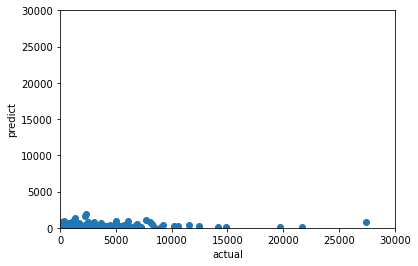

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(train['likes'],lgbm.oof);
plt.xlim(0,30000);
plt.ylim(0,30000);
plt.xlabel('actual');
plt.ylabel('predict');

In [51]:
os.makedirs(f"{OUTPUT_DIR}/imp", exist_ok=True)
feature_importance_df[order[:50]].to_csv(f"{OUTPUT_DIR}/imp/importance.csv")
display(feature_importance_df[order[:50]])

,material_collection_technique_w2v_19,material_collection_w2v_19,material_collection_technique_w2v_3,principal_maker,material_collection_technique_production_country_w2v_7,subtitle_h,principal_or_first_maker,principal_or_first_maker_target_enc,collection_technique_w2v_2,principal_maker_target_enc,...,CE_dating_period,LongTitleEmb_pca_138,AcquisitionDate_year,StringLength__description,DescriptionEmb_pca_40,LongTitleEmb_pca_253,LongTitleEmb_pca_15,CE_description,LongTitleEmb_pca_23,subtitle_d
fold_0,175050.113249,76739.082407,141470.962527,32055.699629,30623.296316,11371.681800,16329.126439,21557.899352,29031.317390,15923.235624,...,4373.002497,1271.064113,1276.483345,1830.399740,861.945475,941.238857,1804.743692,1245.991275,2271.055844,1005.003847
fold_1,111785.990532,88978.320623,239167.729081,28683.371222,29683.049857,12940.898243,19756.239965,21320.870694,6375.695551,16005.464773,...,1808.613410,1492.716565,791.159489,1997.161824,1718.470907,856.081340,1233.031448,2058.236760,1308.070282,1317.378426
fold_2,54870.801571,7182.418929,201396.541184,26817.806532,33181.198348,18843.712491,22662.542343,20451.052527,74120.647555,16710.873006,...,1980.217057,1031.623422,919.235293,2380.547035,1305.561388,1530.945832,1423.409242,3595.894496,2006.347770,1240.262866
fold_3,141413.296297,83794.634791,138355.129495,30432.704880,12260.042656,11817.544532,23456.552761,17968.992951,79076.642913,14385.176823,...,1201.825257,1536.532329,1085.367632,1760.319119,2697.006170,1300.523456,1014.880089,1764.158635,1832.506620,739.841721
fold_4,249239.111050,96290.665597,91241.045845,29022.910712,23017.936272,22795.908456,20274.407204,18581.968896,15727.120068,14618.617392,...,1837.347633,1783.032384,1765.769048,1717.915719,1710.306416,1637.468083,1632.596461,1604.638013,1600.393194,1533.504238


In [52]:
from make_data import make_oof
oof_df = make_oof(OUTPUT_DIR=OUTPUT_DIR, TARGET=cfg['target'])

In [53]:
# from score import calc_macro_auc
# score = calc_macro_auc(train_target_df=train_target_df, oof_df=oof_df, order_list=TARGET_IDS)

In [54]:
sample_sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')

In [55]:
from make_data import make_sub
sub_df = make_sub(sample_sub=sample_sub, TARGET_NAME=cfg['target'], TRIAL_NAME=TRIAL_NAME, OUTPUT_DIR=OUTPUT_DIR, cv_score=lgbm.score)

QUick Sub
sh sub.sh output/20210309233130_32_fix_maker_date_and_place_and_production_place/pred/pred_likes_1.0195.csv


In [56]:
sub_df.describe()

,likes
count,12008.000000
mean,21.712142
std,63.207076
min,0.000000
25%,1.056286
50%,2.512027
75%,6.344141
max,1723.634530


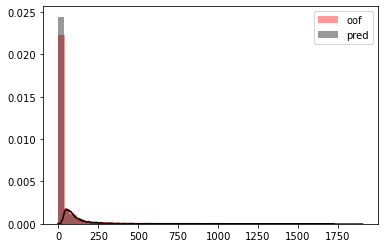

In [57]:
from make_fig import make_dist_oof_pred
make_dist_oof_pred(oof_df=oof_df,sub_df=sub_df,OUTPUT_DIR=OUTPUT_DIR)